## Imports

In [197]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

#SKLearn stuff
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

In [17]:
df = pd.read_csv('data/kc_house_data.csv')

# Header cleaning. More precautionary than anything else
df.columns = [x.strip().lower().replace(' ','').replace('-','') for x in df.columns]
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     19221 non-null  object 
 8   view           21534 non-null  object 
 9   condition      21597 non-null  object 
 10  grade          21597 non-null  object 
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17755 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [19]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## Remove outliers

In [20]:
# Removing outliers
df = df[df['bedrooms'] <=15] #Only 1 record remove. 33 Bed, 1.75 Bath?

## Data Cleaning

sqft_basement is an object?

In [21]:
df.sqft_basement.sort_values()

0        0.0
12644    0.0
12645    0.0
12646    0.0
12648    0.0
        ... 
2126       ?
8548       ?
4776       ?
15185      ?
8565       ?
Name: sqft_basement, Length: 21596, dtype: object

sqft_basement is a list of strings that include some unknowns marked as '?'

In [22]:
df_subset_basement = df[df.sqft_basement !='?'] #drop records where sqft_basement is not '?'
df_subset_basement.sqft_basement = df_subset_basement.sqft_basement.astype(float,)

In [23]:
#check to see how much of the current sqft_basement (excluding '?') can be explained by (sqft_living-sqft_above)

(df_subset_basement.sqft_living - df_subset_basement.sqft_above == df_subset_basement.sqft_basement).sum()/df_subset_basement.shape[0]

1.0

turns out 100%. Fill na using this math

In [24]:
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']

In [25]:
# Change view rating to a numeric value. Probably don't need it
df['view'] = df['view'].map({'EXCELLENT':5,
                             'GOOD':4,
                             'AVERAGE':3,
                             'FAIR':2,
                             'NONE':1})

# Change condition rating to a numeric value. Probably don't need it
df['condition'] = df['condition'].map({'Very Good':5,
                                       'Good':4,
                                       'Average':3,
                                       'Fair':2,
                                       'Poor':1})

# Changing grade to just the numeric value of the grade
df['grade'] = df['grade'].str.split(' ').str[0].astype(int)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21596 non-null  object 
 1   price          21596 non-null  float64
 2   bedrooms       21596 non-null  int64  
 3   bathrooms      21596 non-null  float64
 4   sqft_living    21596 non-null  int64  
 5   sqft_lot       21596 non-null  int64  
 6   floors         21596 non-null  float64
 7   waterfront     19220 non-null  object 
 8   view           21533 non-null  float64
 9   condition      21596 non-null  int64  
 10  grade          21596 non-null  int32  
 11  sqft_above     21596 non-null  int64  
 12  sqft_basement  21596 non-null  int64  
 13  yr_built       21596 non-null  int64  
 14  yr_renovated   17754 non-null  float64
 15  zipcode        21596 non-null  int64  
 16  lat            21596 non-null  float64
 17  long           21596 non-null  float64
 18  sqft_l

In [27]:
#The number of records where view is nan is 0.29% of the dataset. Hence dropped
print(df.view.isna().sum() /df.shape[0])
df.dropna(subset=['view'],inplace=True)

0.0029172068901648454


## Analyzing Corelations

In [28]:
df.corr().price.sort_values()

zipcode         -0.053626
long             0.022428
condition        0.035367
yr_built         0.054284
sqft_lot15       0.083194
sqft_lot         0.090341
yr_renovated     0.129890
floors           0.257069
lat              0.307863
bedrooms         0.315236
sqft_basement    0.321812
view             0.395739
bathrooms        0.525063
sqft_living15    0.585329
sqft_above       0.605719
grade            0.668320
sqft_living      0.701599
price            1.000000
Name: price, dtype: float64

dropping yr_renovated . not enough records

dropping yr_built, floors, date. Not enough correlation. Making predictions based on other columns

keeping zipcode, lat, long for the purpose of potential visualizations

In [29]:
df = df.drop(columns = ['id','yr_renovated','yr_built','floors','date'],axis =1)

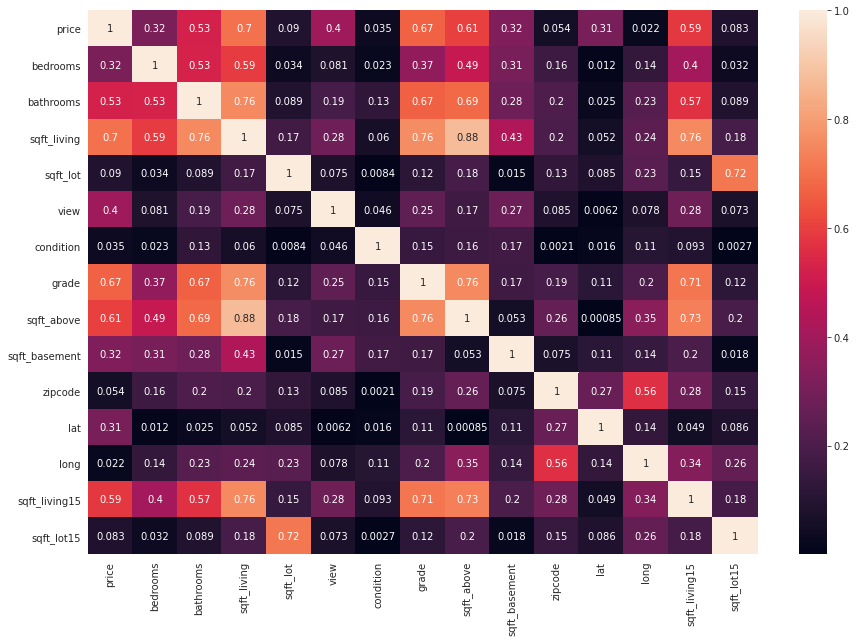

In [30]:
# sns.heatmap(df.corr(),annot=True)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 10))
    ax = sns.heatmap(abs(df.corr()),annot=True)

Note the corelation between
- sqft_living and sqft_above (because sqft_living = sqft_above + sqft_basement). In fact a lot of the sqft are highly corelated
    - try feature engineering between them, or just pick 1 or 2
- grade to sqft_living15, sqft_above
- bathrooms to grade
- grade and sqft_living has highest impact on target (price)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21533 entries, 0 to 21596
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21533 non-null  float64
 1   bedrooms       21533 non-null  int64  
 2   bathrooms      21533 non-null  float64
 3   sqft_living    21533 non-null  int64  
 4   sqft_lot       21533 non-null  int64  
 5   waterfront     19163 non-null  object 
 6   view           21533 non-null  float64
 7   condition      21533 non-null  int64  
 8   grade          21533 non-null  int32  
 9   sqft_above     21533 non-null  int64  
 10  sqft_basement  21533 non-null  int64  
 11  zipcode        21533 non-null  int64  
 12  lat            21533 non-null  float64
 13  long           21533 non-null  float64
 14  sqft_living15  21533 non-null  int64  
 15  sqft_lot15     21533 non-null  int64  
dtypes: float64(5), int32(1), int64(9), object(1)
memory usage: 2.7+ MB


In [32]:
df.isna().sum()

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
waterfront       2370
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

## Train Test split

In [34]:
# Define our X and y
X = df.drop(columns='price')
y = df['price']

In [35]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

## Models

### Model 00. Dummy Regressor

In [36]:
dummy = DummyRegressor() #mean strategy

In [37]:
dummy.fit(X_train,y_train)

DummyRegressor()

In [38]:
dummy.score(X_train,y_train)

0.0

In [39]:
dummy.score(X_test,y_test)

-0.0009077283532201719

Dummy Regressor has a 0 R^2 score?

### Model 0. Using highest corr coefficient feature: sqft_living

In [56]:
df.corr().price.sort_values()[-2:]

sqft_living    0.701599
price          1.000000
Name: price, dtype: float64

In [57]:
cols = ['sqft_living']

In [58]:
X_train_subset = X_train[cols]
X_test_subset = X_test[cols]

In [62]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train) 
print("Training Score:",pipe.score(X_train_subset, y_train))
print("Test Score:",pipe.score(X_test_subset, y_test))

Training Score: 0.4905573788963036
Test Score: 0.49583152405969266


Any chosen model should perform better than this

###  Model 1 : Sqft_living, grade

Note: These should have a high colinearity. Just curious

In [64]:
cols = ['sqft_living','grade']

In [65]:
X_train_subset = X_train[cols]
X_test_subset = X_test[cols]

In [66]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train) 
print("Training Score:",pipe.score(X_train_subset, y_train))
print("Test Score:",pipe.score(X_test_subset, y_test))

Training Score: 0.5340719478317577
Test Score: 0.5360131874314007


### Model 2: Sqft_living/Sqft_living15, grade

Feature engineering a ratio of living area to that of the neighborhood. Thinking: biggest house in the neighborhood is a good predicter

In [71]:
cols = ['sqft_living','sqft_living15','grade']

In [72]:
X_train_subset = X_train[cols]
X_train_subset['sqft_living / sqft_living15'] = X_train_subset['sqft_living'] / X_train_subset['sqft_living15']
X_train_subset.drop(columns = ['sqft_living', 'sqft_living15'],inplace = True)

In [73]:
X_test_subset = X_test[cols]
X_test_subset['sqft_living / sqft_living15'] = X_test_subset['sqft_living'] / X_test_subset['sqft_living15']
X_test_subset.drop(columns = ['sqft_living', 'sqft_living15'],inplace = True)

In [74]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train) 
print("Training Score:",pipe.score(X_train_subset, y_train))
print("Test Score:",pipe.score(X_test_subset, y_test))

Training Score: 0.4615350734798367
Test Score: 0.4568798474890984


yeesh

### Model 3: Sqft_living, Sqft_lot

Trying variations of Sqft_living and Sqft_lot
Thinking: Either individually, an addition or a ratio of the living/lot might be a good predicter

In [78]:
cols = ['sqft_living','sqft_lot']

In [79]:
X_train_subset = X_train[cols]
X_test_subset = X_test[cols]

In [80]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train) 
print("Training Score:",pipe.score(X_train_subset, y_train))
print("Test Score:",pipe.score(X_test_subset, y_test))

Training Score: 0.492049768137209
Test Score: 0.4954390341075747


probably also has high multicolinarity. Also, not much better than Model 0

### Model 3a: Sqft_living + Sqft_lot, grade

In [91]:
cols = ['sqft_living','sqft_lot','grade']

In [92]:
X_train_subset = X_train[cols]
X_train_subset['sqft_living + sqft_lot'] = X_train_subset['sqft_living'] + X_train_subset['sqft_lot']
X_train_subset.drop(columns = ['sqft_living', 'sqft_lot'],inplace = True)

In [93]:
X_test_subset = X_test[cols]
X_test_subset['sqft_living + sqft_lot'] = X_test_subset['sqft_living'] + X_test_subset['sqft_lot']
X_test_subset.drop(columns = ['sqft_living', 'sqft_lot'],inplace = True)

In [94]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train) 
print("Training Score:",pipe.score(X_train_subset, y_train))
print("Test Score:",pipe.score(X_test_subset, y_test))

Training Score: 0.4480908124949592
Test Score: 0.443878395153508


blech

### Model 4: View, Waterfront, Grade

Something different. No square footage. Based on view, waterfront, grade. Will require little more work, since waterfront has a bunch of nulls

In [101]:
cols = ['view','waterfront','grade']

In [102]:
df['waterfront'].isna().sum()/df.shape[0]

0.1100636232759021

11% of data in original data set is empty for water front. Dropping these for this particular model and re running train/test split

In [104]:
df_waterfront_model = df.dropna(subset=['waterfront'])
df_waterfront_model.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15
1,538000.0,3,2.25,2570,7242,NO,1.0,3,7,2170,400,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,NO,1.0,3,6,770,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,NO,1.0,5,7,1050,910,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,NO,1.0,3,8,1680,0,98074,47.6168,-122.045,1800,7503
5,1230000.0,4,4.50,5420,101930,NO,1.0,3,11,3890,1530,98053,47.6561,-122.005,4760,101930


In [105]:
# Train test split
X_train_waterfront, X_test_waterfront, y_train_waterfront, y_test_waterfront = train_test_split(
    df_waterfront_model.drop(columns='price'), 
    df_waterfront_model['price'], 
    test_size=0.25, 
    random_state=42)

In [106]:
#Going to use Ordinal Encoder to transform waterfront

# (1) (Use double brackets [[]] to get the appropriate shape)
waterfront_train = X_train_waterfront[['waterfront']]

# (2) Instantiate an OrdinalEncoder
encoder_waterfront = OrdinalEncoder()

# (3) Fit the encoder on street_train
encoder_waterfront.fit(waterfront_train)

# (4) Transform street_train using the encoder and
# assign the result to street_encoded_train
waterfront_encoded_train = encoder_waterfront.transform(waterfront_train).flatten()

waterfront_test = X_test_waterfront[['waterfront']]
waterfront_encoded_test = encoder_waterfront.transform(waterfront_test).flatten()

X_train_waterfront['waterfront'] = waterfront_encoded_train
X_test_waterfront['waterfront'] = waterfront_encoded_test


In [107]:
X_train_subset = X_train_waterfront[cols]
X_test_subset = X_test_waterfront[cols]

In [109]:
#NOTE: Cannot use y_train and y_test here.  Use waterfront!

pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train_waterfront) 
print("Training Score:",pipe.score(X_train_subset, y_train_waterfront))
print("Test Score:",pipe.score(X_test_subset, y_test_waterfront))

Training Score: 0.5148790539188103
Test Score: 0.5298641528517465


Better, but meh. Marginally better than Model 0

### Model 5: Bedroom, Bathroom, sqft_living

ok. ignoring square footage probably not a good idea. Using room counts as a predicter

In [136]:
cols = ['bedrooms','bathrooms','sqft_living']

In [137]:
X_train_subset = X_train[cols]
X_test_subset = X_test[cols]

In [138]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train) 
print("Training Score:",pipe.score(X_train_subset, y_train))
print("Test Score:",pipe.score(X_test_subset, y_test))

Training Score: 0.5069510092368094
Test Score: 0.5100687713895246


### Model 6a: Bedroom, Bathroom, sqft_living, grade

In [141]:
cols = ['bedrooms','bathrooms','sqft_living','grade']

In [142]:
X_train_subset = X_train[cols]
X_test_subset = X_test[cols]

In [143]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train) 
print("Training Score:",pipe.score(X_train_subset, y_train))
print("Test Score:",pipe.score(X_test_subset, y_test))

Training Score: 0.5437295802021231
Test Score: 0.5458050736113481


Hmmm... Including sqft_living AND grade increased scores. But their corelation is high. Probably high multicolinearity. Check a few more models

### Model 6b: Bedroom/Bathroom, sqft_living, grade

Slight feature engineering. Ratio of bedrooms to bathrooms

In [158]:
cols = ['bedrooms','bathrooms','sqft_living','grade']

In [159]:
X_train_subset = X_train[cols]
X_test_subset = X_test[cols]

X_train_subset['bedrooms/bathrooms'] = X_train_subset['bedrooms']/X_train_subset['bathrooms']
X_test_subset['bedrooms/bathrooms'] = X_test_subset['bedrooms']/X_test_subset['bathrooms']

X_train_subset.drop(columns = ['bedrooms','bathrooms'],inplace = True)
X_test_subset.drop(columns = ['bedrooms','bathrooms'],inplace = True)

In [160]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train) 
print("Training Score:",pipe.score(X_train_subset, y_train))
print("Test Score:",pipe.score(X_test_subset, y_test))

Training Score: 0.5347960565349933
Test Score: 0.5371075750878966


Not that much better

## Ze Kitchen Sink

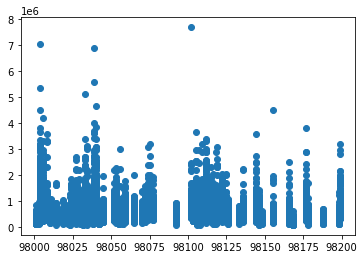

In [173]:
fig, ax = plt.subplots()
ax.scatter(df['zipcode'],df['price'])

If considering zip code, I think it should be considered as a categorical

### Model 7a: zipcode included, still as a value

Feel like zipcode should be considered a categorical. Its like the name of a neighborhood. Trying it as a value  first

In [152]:
df.head(1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.0,1180,5650,NaN,1.0,3,7,1180,0,98178,47.5112,-122.257,1340,5650


In [161]:
cols = ['bedrooms','bathrooms','sqft_living','condition','zipcode']

In [162]:
X_train_subset = X_train[cols]
X_test_subset = X_test[cols]

In [163]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train) 
print("Training Score:",pipe.score(X_train_subset, y_train))
print("Test Score:",pipe.score(X_test_subset, y_test))

Training Score: 0.5221279613417303
Test Score: 0.5252101045097386


### Model 7b: zipcode included, as a categorical

In [170]:
cols = ['bedrooms','bathrooms','sqft_living','view','condition','zipcode']
X_train_subset = X_train[cols]
X_test_subset = X_test[cols]

In [171]:
# Because the number of columns in the encoded matrix, is high, the output has to be made explicitly .toarray() or .todense()

encoder = OneHotEncoder(handle_unknown='error',
                        drop='first',
                        categories='auto')

catcols = ['zipcode']
ct = ColumnTransformer(transformers=[('ohe', encoder, catcols)],
                       remainder='passthrough')



ct.fit(X_train_subset)
X_train_enc = ct.transform(X_train_subset).todense()
X_test_enc = ct.transform(X_test_subset).todense()

In [172]:
#USE encoded training and test  sets here!

pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_enc, y_train) 
print("Training Score:",pipe.score(X_train_enc, y_train))
print("Test Score:",pipe.score(X_test_enc, y_test))

Training Score: 0.7716774865180858
Test Score: 0.766401462813862


PROMISING! 

$_{only~thing~so~far}$

## Deepdive in Model 7b

Get all the necessary variables (R^2, Condition No, p-values, coeffiencts, intercept, MAE, RMSE)

### First a sanity check. Manual Run of methods

OneHotEncoder already applied

In [186]:
#Scale
scaler = StandardScaler()
scaler.fit(X_train_enc,y_train)

X_train_scaled = scaler.transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

In [190]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

train_preds=lr.predict(X_train_scaled)
test_preds=lr.predict(X_test_scaled)

In [192]:
print('Training Score:',r2_score(y_train,train_preds))
print('Test Score:',r2_score(y_test,test_preds))

Training Score: 0.7716774865180858
Test Score: 0.766401462813862


### OLS Summary

In [205]:
#Just to get summary
model = sm.OLS(endog=y_train, exog=sm.add_constant(X_train_scaled)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     685.0
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        13:07:16   Log-Likelihood:            -2.0339e+05
No. Observations:               15073   AIC:                         4.069e+05
Df Residuals:                   14998   BIC:                         4.075e+05
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.433e+05   1432.264    379.357      0.000    5.41e+05    5.46e+05
x1          1966.5406   1786.095      1.101      0.271   -1534.424    5467.505
x2          -783.0974   1924.201     -0.407      0.684   -4554.767    2988.573
x3          9.945e+04   1991.198     49.945      0.000    9.55e+04    1.03e+05
x4          3.083e+04   1758.001     17.536      0.000    2.74e+04    3.43e+04
x5          4.658e+04   2256.398     20.643      0.000    4.22e+04     5.1e+04
x6          2.269e+04   1719.394     13.194      0.000    1.93e+04    2.61e+04
x7          3.376e+04   1935.492     17.442      0.000       3e+04    3.76e+04
x8          5409.4390   1620.506      3.338      0.001    2233.049    8585.829
x9          1.327e+04   1803.266      7.360      0.000    9737.188    1.68e+04
x10         8790.1596   1652.076      5.321      0.000    5551.889     1.2e+04
x11         8494.9923   1776.118      4.783      0.000    5013.583     1.2e+04
x12        -2591.2275   1832.420     -1.414      0.157   -6182.994    1000.539
x13        -3063.4392   2218.819     -1.381      0.167   -7412.596    1285.718
x14         1.104e+04   1587.496      6.951      0.000    7923.354    1.41e+04
x15          2.41e+04   2107.256     11.435      0.000       2e+04    2.82e+04
x16         1.452e+04   1928.817      7.527      0.000    1.07e+04    1.83e+04
x17         2.986e+04   2016.198     14.812      0.000    2.59e+04    3.38e+04
x18         1222.5733   1887.734      0.648      0.517   -2477.616    4922.763
x19         1761.2323   1886.141      0.934      0.350   -1935.834    5458.298
x20          -80.2640   1659.694     -0.048      0.961   -3333.467    3172.939
x21         5.387e+04   2120.322     25.407      0.000    4.97e+04     5.8e+04
x22          3.33e+04   2267.714     14.686      0.000    2.89e+04    3.77e+04
x23         5019.8188   2348.980      2.137      0.033     415.532    9624.106
x24          6.64e+04   1543.568     43.016      0.000    6.34e+04    6.94e+04
x25         6.446e+04   1930.124     33.398      0.000    6.07e+04    6.82e+04
x26         1933.1761   2265.362      0.853      0.393   -2507.211    6373.563
x27         7929.6157   1819.862      4.357      0.000    4362.463    1.15e+04
x28         4.269e+04   2339.109     18.250      0.000    3.81e+04    4.73e+04
x29         2.934e+04   2141.735     13.697      0.000    2.51e+04    3.35e+04
x30         4912.6170   1896.303      2.591      0.010    1195.632    8629.602
x31         1.207e+04   2103.150      5.739      0.000    7947.185    1.62e+04
x32         5947.2730   2172.192      2.738      0.006    1689.512    1.02e+04
x33         1.524e+04   2197.650      6.934      0.000    1.09e+04    1.95e+04
x34         8329.6701   1985.814      4.195      0.000    4437.232    1.22e+04
x35         5786.1702   1675.303      3.454      0.001    2502.371    9069.970
x3

Lines up perfectly with the pipeline method

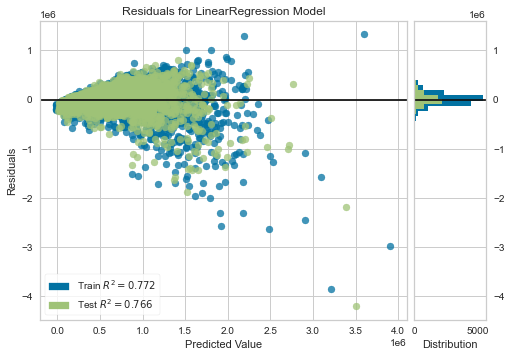

In [193]:
# visualizing our residuals 
# https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

In [217]:
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds
train_residuals

9910      70861.521950
13829    -69290.534149
7360     150004.425208
17118     94792.442786
13811    176557.073577
             ...      
11323   -142609.444163
12006     67598.066356
5409    -149445.895188
866     -290655.554120
15848    -51610.165885
Name: price, Length: 15073, dtype: float64

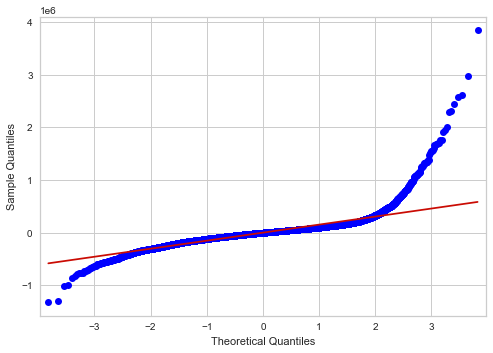

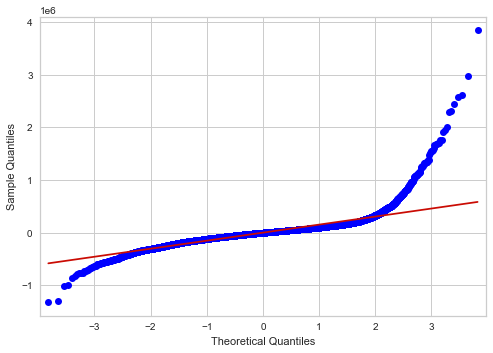

In [218]:
sm.qqplot(train_residuals, line = 'r')

In [221]:
pd.DataFrame(X_train_scaled, columns=ct.get_feature_names())

,ohe__x0_98002,ohe__x0_98003,ohe__x0_98004,ohe__x0_98005,ohe__x0_98006,ohe__x0_98007,ohe__x0_98008,ohe__x0_98010,ohe__x0_98011,ohe__x0_98014,...,ohe__x0_98177,ohe__x0_98178,ohe__x0_98188,ohe__x0_98198,ohe__x0_98199,bedrooms,bathrooms,sqft_living,view,condition
0,-0.095065,-0.115373,-0.122822,-0.089959,-0.155754,-0.084555,-0.116255,-0.067319,-0.097867,-0.073047,...,-0.108694,-0.105847,-0.080061,-0.109628,-0.122264,0.694151,-1.453921,-0.603490,-0.304305,-0.633269
1,-0.095065,-0.115373,-0.122822,-0.089959,-0.155754,-0.084555,8.601747,-0.067319,-0.097867,-0.073047,...,-0.108694,-0.105847,-0.080061,-0.109628,-0.122264,-0.415858,-0.160202,0.522024,-0.304305,-0.633269
2,-0.095065,-0.115373,-0.122822,-0.089959,-0.155754,-0.084555,-0.116255,-0.067319,-0.097867,-0.073047,...,-0.108694,-0.105847,-0.080061,-0.109628,-0.122264,-0.415858,-0.807062,-0.776646,-0.304305,0.911022
3,-0.095065,-0.115373,-0.122822,-0.089959,-0.155754,-0.084555,-0.116255,-0.067319,-0.097867,-0.073047,...,-0.108694,-0.105847,-0.080061,-0.109628,-0.122264,0.694151,0.486657,-0.462800,-0.304305,-0.633269
4,-0.095065,-0.115373,-0.122822,-0.089959,-0.155754,-0.084555,-0.116255,-0.067319,-0.097867,-0.073047,...,-0.108694,-0.105847,-0.080061,-0.109628,-0.122264,0.694151,0.810087,-0.852401,-0.304305,-2.177560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15068,-0.095065,-0.115373,-0.122822,-0.089959,-0.155754,-0.084555,-0.116255,-0.067319,-0.097867,-0.073047,...,-0.108694,-0.105847,-0.080061,-0.109628,-0.122264,0.694151,1.780377,1.420271,-0.304305,-0.633269
15069,-0.095065,-0.115373,8.141878,-0.089959,-0.155754,-0.084555,-0.116255,-0.067319,-0.097867,-0.073047,...,-0.108694,-0.105847,-0.080061,-0.109628,-0.122264,-0.415858,-0.483632,0.370513,2.309253,0.911022
15070,-0.095065,-0.115373,-0.122822,-0.089959,-0.155754,-0.084555,-0.116255,-0.067319,-0.097867,-0.073047,...,-0.108694,-0.105847,-0.080061,-0.109628,-0.122264,-1.525866,-1.453921,-0.506089,-0.304305,-0.633269
15071,-0.095065,-0.115373,-0.122822,-0.089959,-0.155754,-0.084555,-0.116255,-0.067319,-0.097867,-0.073047,...,-0.108694,-0.105847,-0.080061,-0.109628,-0.122264,-0.415858,0.486657,1.485205,-0.304305,-0.633269


In [219]:
sns.heatmap(X_train_scaled.corr(),annot=True)

AttributeError: 'numpy.ndarray' object has no attribute 'corr'

## Some weird plots

In [ ]:
df_pairplotting1 = df.filter(['bedrooms','bathrooms','floors','view','condition','price'])
df_pairplotting2 = df.filter(['bedrooms','sqft_living', 'sqft_lot','sqft_above','sqft_living15', 'sqft_lot15','price'])

In [ ]:
sns.pairplot(df_pairplotting1)

In [ ]:
sns.pairplot(df_pairplotting2)